In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
data_final=pd.read_csv("/content/finance_data.csv")

In [42]:
df = data_final[data_final['US_Bank'] == 'BAC'].copy()

# Chuyển Date sang datetime và sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Reset index integer để tránh lỗi ARIMA
df.reset_index(drop=True, inplace=True)
df['Close'].ffill(inplace=True)  # điền NaN

print("Dữ liệu đầu:", df.head())


Dữ liệu đầu:    Unnamed: 0       Date US_Bank       Open       High        Low      Close  \
0           0 2015-10-14     BAC  15.770000  15.920000  15.550000  15.640000   
1           1 2015-10-15     BAC  15.810000  16.280001  15.720000  16.190001   
2           2 2015-10-16     BAC  16.290001  16.290001  16.030001  16.120001   
3           3 2015-10-19     BAC  16.000000  16.209999  15.980000  16.139999   
4           4 2015-10-20     BAC  16.160000  16.290001  16.100000  16.200001   

   Adjusted Close     Volume  
0       12.591779  122272400  
1       13.034586  127028800  
2       12.978229   66989500  
3       12.994333   62953500  
4       13.042639   50797800  


/tmp/ipython-input-2265229744.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].ffill(inplace=True)  # điền NaN


#Applying time series modelling to build algorithms trading

##Tính lợi nhuận và volatility

In [43]:
df['Return'] = df['Close'].pct_change()   # Lợi nhuận hàng ngày (simple return)
df.dropna(subset=['Return'], inplace=True)

# Volatility rolling 20 phiên (~1 tháng)
df['Volatility'] = df['Return'].rolling(window=20).std()
df.dropna(subset=['Volatility'], inplace=True)

##Time Series Modelling (ARIMA) :dự đoán lợi nhuận

In [44]:
model = ARIMA(df['Return'], order=(1,0,1))
model_fit = model.fit()

# Dự báo
df['Forecast'] = model_fit.predict(start=0, end=len(df)-1)

print("Dữ liệu sau dự báo:", df[['Return','Forecast']].head())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Dữ liệu sau dự báo:       Return  Forecast
20 -0.005602  0.000594
21 -0.021408  0.000831
22 -0.009787  0.001260
23  0.013372  0.000544
24 -0.000574  0.000158


##Tính Bollinger Bands (Mean Reversion)

In [45]:
window = 20
df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
df['Rolling_Std'] = df['Close'].rolling(window=window).std()
df['Upper_Band'] = df['Rolling_Mean'] + 2*df['Rolling_Std']
df['Lower_Band'] = df['Rolling_Mean'] - 2*df['Rolling_Std']
df.dropna(inplace=True)


##Tạo tín hiệu giao dịch (Signal)

In [46]:
# Buy nếu giá < Lower_Band và dự báo > 0
buy_condition = (df['Close'] < df['Lower_Band']) & (df['Forecast'] > 0)
# Sell nếu giá > Upper_Band và dự báo < 0
sell_condition = (df['Close'] > df['Upper_Band']) & (df['Forecast'] < 0)
df['Signal'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))


#Tạo Position (shift 1 ngày để tránh lookahead bias)


In [47]:
df['Position'] = df['Signal'].shift(1)
df.dropna(inplace=True)

##Tính lợi nhuận chiến lược

In [48]:
df['Strategy_Return'] = df['Position'] * df['Return']

# Cumulative returns (simple return)
df['Cumulative_Market'] = (1 + df['Return']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()


##Tính Sharpe Ratio (annualized)

In [49]:
if df['Strategy_Return'].std() != 0:
    sharpe_ratio = (df['Strategy_Return'].mean() / df['Strategy_Return'].std()) * np.sqrt(252)
else:
    sharpe_ratio = np.nan
print(f"Sharpe Ratio của chiến lược: {sharpe_ratio}")


Sharpe Ratio của chiến lược: -0.2808922999534493


##Vẽ biểu đồ cumulative returns

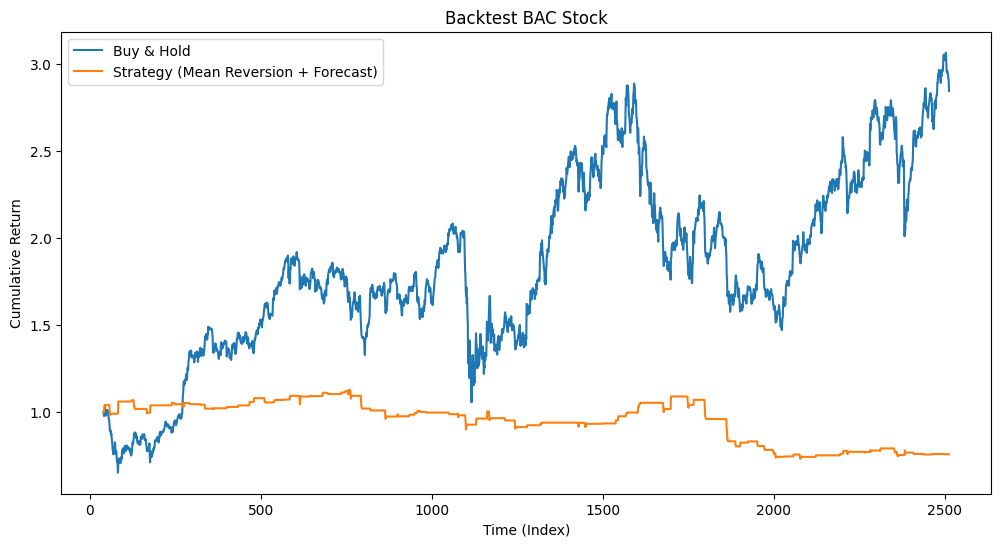

In [50]:
plt.figure(figsize=(12,6))
plt.plot(df['Cumulative_Market'], label='Buy & Hold')
plt.plot(df['Cumulative_Strategy'], label='Strategy (Mean Reversion + Forecast)')
plt.title('Backtest BAC Stock')
plt.xlabel('Time (Index)')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



##Kiểm tra dữ liệu cuối

In [51]:
print(df[['Close','Lower_Band','Upper_Band','Forecast','Signal','Position','Strategy_Return','Cumulative_Strategy']].tail())


          Close  Lower_Band  Upper_Band  Forecast  Signal  Position  \
2508  50.389999   49.690394   52.745606  0.000506       0       0.0   
2509  50.290001   49.690394   52.745606  0.000854       0       0.0   
2510  49.840000   49.627666   52.779334  0.000520       0       0.0   
2511  49.790001   49.467045   52.843955  0.000991       0       0.0   
2512  48.650002   49.043180   53.074820  0.000394       1       0.0   

      Strategy_Return  Cumulative_Strategy  
2508             -0.0             0.758641  
2509             -0.0             0.758641  
2510             -0.0             0.758641  
2511             -0.0             0.758641  
2512             -0.0             0.758641  
